In [1]:
# config
import sys
import numpy as np
import torch
assert torch.cuda.is_available()
%matplotlib inline
cuda_device = torch.device("cuda:0")
torch.cuda.set_device(cuda_device)
from config import config
setting = config(
    cuda_device, 
    mode = "whole",
    model_save_name="/home/zzn/PycharmProjects/RESNET_FPN/StateDicts/CSRPersNet_A_7_25.pkl", 
    dataset_name="SHA",
    lr=1e-6, 
    batch_size=1, 
    eval_per_step=300
)

In [2]:
# data_load
from Dataset.DatasetConstructor import TrainDatasetConstructor,EvalDatasetConstructor
train_dataset = TrainDatasetConstructor(
    setting.train_num,
    setting.train_img_path,
    setting.train_gt_map_path,
    setting.train_pers_path,
    mode=setting.mode,
    dataset_name=setting.dataset_name,
    device=setting.cuda_device,
    if_random_hsi=setting.if_random_hsi,
    if_flip=setting.if_random_hsi)
eval_dataset = EvalDatasetConstructor(
    setting.eval_num,
    setting.eval_img_path,
    setting.eval_gt_map_path,
    setting.eval_pers_path,
    mode=setting.mode,
    dataset_name=setting.dataset_name,
    device=setting.cuda_device)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=setting.train_batch_size)
eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset, batch_size=1)

In [3]:
# model construct
from net.RES_PERS_FPN.PERS_FPN import PERS_FPN
from eval.Estimator import Estimator
from net.CSRPersNet import CSRPersNet
from collections import OrderedDict
# net = FPN().to(setting.cuda_device)
net = CSRPersNet(sigma=[1, 1, 0, 2], updates_signal=[True, True, True, True]).to(setting.cuda_device)
# net = PERS_FPN(sigma=[1, 1, 0, 1], updates_signal=[True, True, True, True]).to(setting.cuda_device)
main_params, ada_sig_params = net.get_params()
optimizerW = torch.optim.Adam({*main_params}, setting.learning_rate)
optimizerD = torch.optim.Adam({*ada_sig_params}, 1e-4)
criterion = torch.nn.MSELoss(reduction='sum').to(setting.cuda_device)
estimator = Estimator(setting, eval_loader, criterion=criterion)

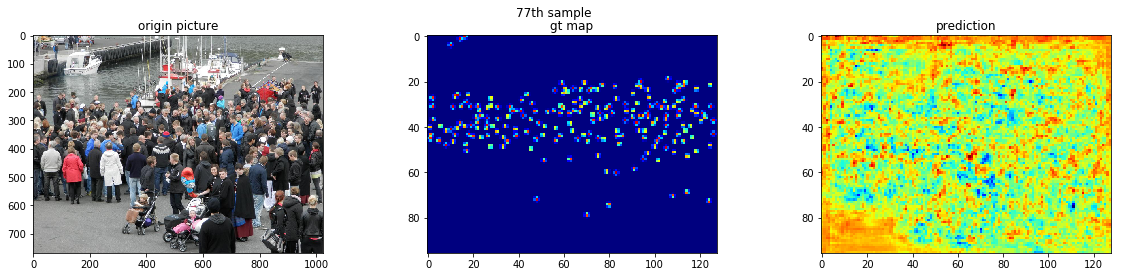

The gt counts of the above sample:207, and the pred counts:-281.95159912109375
In step 0, epoch 0, loss = 236.59191277262929, eval_mae = 619.1454467773438, eval_rmse = 718.67822265625, time cost eval = 16.526888847351074s


In [ ]:
import time
step = 0
eval_loss, eval_mae, eval_rmse = [], [], []
for epoch_index in range(setting.epoch):
    dataset = train_dataset.shuffle()
    loss_list = []
    time_per_epoch = 0
    for train_img_index, train_img, train_gt, train_pers in train_loader:
        if step % setting.eval_per_step == 0:
            validate_MAE, validate_RMSE, validate_loss, time_cost = estimator.evaluate(net, True)
            eval_loss.append(validate_loss)
            eval_mae.append(validate_MAE)
            eval_rmse.append(eval_rmse)
            sys.stdout.write(
                'In step {}, epoch {}, loss = {}, eval_mae = {}, eval_rmse = {}, time cost eval = {}s\n'
                .format(step, epoch_index, validate_loss, validate_MAE,
                        validate_RMSE, time_cost))
            sys.stdout.flush()
            # save model
            if setting.min_mae > validate_MAE:
                setting.min_mae = validate_MAE
                torch.save(net.state_dict(), setting.model_save_path)
                
        net.train()
        torch.cuda.empty_cache()
        x, y = train_img, train_gt
        prediction = net(x, train_pers)
        loss = criterion(prediction, y)
        
        if step % 3 == 2:
            optimizerD.zero_grad()
            loss.backward()
            loss_list.append(loss.data.item())
            optimizerD.step()
        else :
            optimizerW.zero_grad()
            loss.backward()
            loss_list.append(loss.data.item())
            optimizerW.step()

        step += 1